Название проекта - Удовлетворенность сотрудников компании.

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

файлы:

Тренировочная выборка:
train_job_satisfaction_rate.csv
Входные признаки тестовой выборки:
test_features.csv
Целевой признак тестовой выборки:
test_target_job_satisfaction_rate.csv

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Для этой задачи вы будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

Тренировочная выборка:
train_quit.csv
Входные признаки тестовой выборки те же, что и в прошлой задаче:
test_features.csv
Целевой признак тестовой выборки:
test_target_quit.csv


## 0. Подготовительные шаги

### 0.1 Импорт библиотек

In [1]:
!pip install imbalanced-learn -q
!pip install phik -q
!pip install shap -q
#!pip install scikit-learn==1.4.0 -q
!pip install --upgrade scikit-learn -q
!pip install -U matplotlib -q

In [2]:
import os
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import LabelEncoder
# импортируем классы для опредлеления нормальности распределения
from scipy.stats import shapiro, normaltest

from imblearn.over_sampling import RandomOverSampler


### 0.2 Объявление констант

In [3]:
#константа локального пути
LOCAL_DATA_PATH = 'c:/ps/project/HR/data/'

#константа пути в тренажере
TRAINER_DATA_PATH = '/datasets/'

#список имен датафреймов
DF_NAMES = ['df_train_job_satisfaction_rate', 'df_test_features', 'df_test_target_job_satisfaction_rate', 'df_train_quit', 'df_test_target_quit']

# константа новой строки для использования в f' строках
NL = '\n'

RANDOM_STATE = 42

### 0.3 Объявление функции для новой метрики:

In [4]:
def smape(a, f):
    return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

## 1. Загрузка данных

In [5]:
for f in DF_NAMES:
    if os.path.exists(LOCAL_DATA_PATH):
        globals()[f] = pd.read_csv(LOCAL_DATA_PATH + f.strip('df_') + '.csv', index_col='id')
    elif os.path.exists(TRAINER_DATA_PATH):
        globals()[f] = pd.read_csv(TRAINER_DATA_PATH + f.strip('df_') + '.csv', index_col='id')
    else:
        print('Warning: no files found')

In [6]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].sample(5))

Датасет df_train_job_satisfaction_rate


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
890731,technology,junior,low,1,no,no,2,21600,0.35
645504,marketing,junior,low,1,no,no,3,13200,0.36
911309,sales,middle,medium,7,no,yes,2,42000,0.39
512633,technology,junior,low,1,no,no,4,15600,0.55
122260,technology,middle,medium,6,no,no,4,39600,0.64


Датасет df_test_features


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
469246,sales,junior,low,2,no,no,5,12000
369763,technology,junior,high,1,no,no,4,39600
258615,hr,junior,high,1,no,no,3,39600
948968,marketing,junior,medium,2,no,no,4,32400
695135,technology,junior,medium,1,no,no,4,36000


Датасет df_test_target_job_satisfaction_rate


,job_satisfaction_rate
id,
152132,0.23
903606,0.70
161234,0.74
439453,0.33
624482,0.92


Датасет df_train_quit


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
423851,purchasing,middle,high,8,no,yes,3,49200,no
636168,purchasing,middle,medium,5,no,no,3,37200,no
557237,technology,middle,high,7,no,no,1,55200,no
900164,marketing,middle,low,2,no,no,5,31200,no
278033,purchasing,junior,medium,1,no,yes,2,21600,yes


Датасет df_test_target_quit


,quit
id,
647748,yes
696192,yes
663607,no
512547,no
334948,no


In [7]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


## 2. Предобработка данных

### 2.1 Проверка пропусков

In [8]:
# посмотрим есть ли пропуски

for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].info())
    for i in globals()[f].columns:
        print('-----------------')
        print('                 ')
        print(f'Датасет {f}, столбец {i}')
        display(globals()[f][i].unique())
    print('----------------------------------------------')
    print('----------------------------------------------')

Датасет df_train_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец dept


array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец level


array(['junior', 'middle', 'sinior', nan], dtype=object)

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец workload


array(['medium', 'high', 'low'], dtype=object)

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец employment_years


array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец last_year_promo


array(['no', 'yes'], dtype=object)

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец last_year_violations


array(['no', 'yes'], dtype=object)

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец supervisor_evaluation


array([1, 5, 2, 3, 4])

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец salary


array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200])

-----------------
                 
Датасет df_train_job_satisfaction_rate, столбец job_satisfaction_rate


array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

----------------------------------------------
----------------------------------------------
Датасет df_test_features
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

-----------------
                 
Датасет df_test_features, столбец dept


array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

-----------------
                 
Датасет df_test_features, столбец level


array(['junior', 'middle', 'sinior', nan], dtype=object)

-----------------
                 
Датасет df_test_features, столбец workload


array(['medium', 'low', 'high', ' '], dtype=object)

-----------------
                 
Датасет df_test_features, столбец employment_years


array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10])

-----------------
                 
Датасет df_test_features, столбец last_year_promo


array(['no', 'yes'], dtype=object)

-----------------
                 
Датасет df_test_features, столбец last_year_violations


array(['no', 'yes'], dtype=object)

-----------------
                 
Датасет df_test_features, столбец supervisor_evaluation


array([5, 4, 3, 1, 2])

-----------------
                 
Датасет df_test_features, столбец salary


array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
       36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
       18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
       58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
       38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
       72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
       94800, 82800, 80400, 87600, 86400, 96000, 78000, 75600, 73200,
       84000, 88800, 92400])

----------------------------------------------
----------------------------------------------
Датасет df_test_target_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


None

-----------------
                 
Датасет df_test_target_job_satisfaction_rate, столбец job_satisfaction_rate


array([0.74, 0.75, 0.6 , 0.72, 0.08, 0.76, 0.64, 0.38, 0.14, 0.59, 0.91,
       0.78, 0.7 , 0.79, 0.34, 0.81, 0.23, 0.4 , 0.58, 0.77, 0.68, 0.24,
       0.42, 0.69, 0.47, 0.35, 0.71, 0.83, 0.61, 0.65, 0.37, 0.45, 0.63,
       0.82, 0.16, 0.89, 0.28, 0.32, 0.88, 0.36, 0.33, 0.31, 0.27, 0.73,
       0.53, 0.26, 0.57, 0.2 , 1.  , 0.56, 0.67, 0.19, 0.52, 0.43, 0.12,
       0.11, 0.21, 0.13, 0.49, 0.22, 0.86, 0.46, 0.41, 0.48, 0.29, 0.87,
       0.66, 0.8 , 0.55, 0.5 , 0.51, 0.62, 0.85, 0.84, 0.15, 0.39, 0.25,
       0.9 , 0.07, 0.1 , 0.92, 0.3 , 0.44, 0.18, 0.93, 0.54, 0.96, 0.09,
       0.99, 0.17, 0.95, 0.06, 0.94, 0.03, 0.98, 0.97, 0.04, 0.05])

----------------------------------------------
----------------------------------------------
Датасет df_train_quit
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

-----------------
                 
Датасет df_train_quit, столбец dept


array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

-----------------
                 
Датасет df_train_quit, столбец level


array(['middle', 'junior', 'sinior'], dtype=object)

-----------------
                 
Датасет df_train_quit, столбец workload


array(['high', 'medium', 'low'], dtype=object)

-----------------
                 
Датасет df_train_quit, столбец employment_years


array([ 2,  5,  1,  8,  4,  7,  3,  9,  6, 10])

-----------------
                 
Датасет df_train_quit, столбец last_year_promo


array(['no', 'yes'], dtype=object)

-----------------
                 
Датасет df_train_quit, столбец last_year_violations


array(['no', 'yes'], dtype=object)

-----------------
                 
Датасет df_train_quit, столбец supervisor_evaluation


array([4, 1, 3, 5, 2])

-----------------
                 
Датасет df_train_quit, столбец salary


array([54000, 27600, 37200, 24000, 25200, 18000, 44400, 19200, 45600,
       57600, 33600, 16800, 22800, 26400, 82800, 32400, 39600, 30000,
       46800, 12000, 15600, 58800, 60000, 66000, 21600, 38400, 62400,
       40800, 56400, 34800, 28800, 52800, 20400, 36000, 61200, 48000,
       43200, 73200, 31200, 78000, 64800, 72000, 94800, 96000, 63600,
       79200, 55200, 42000, 49200, 50400, 14400, 13200, 51600, 67200,
       88800, 68400, 69600, 70800, 84000, 81600, 87600, 75600, 91200,
       76800, 74400, 80400, 85200, 86400, 92400])

-----------------
                 
Датасет df_train_quit, столбец quit


array(['no', 'yes'], dtype=object)

----------------------------------------------
----------------------------------------------
Датасет df_test_target_quit
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

-----------------
                 
Датасет df_test_target_quit, столбец quit


array(['yes', 'no'], dtype=object)

----------------------------------------------
----------------------------------------------


в датасете df_test_features в столбцах dept и workload  помимо пропусков есть еще пустое(ые) значение(я), их нужно переделать на пропуски ( а затем обработать их в пайплайне). Кроме того, неявных дубликатов/опечаток нет.

In [9]:
# конвертируем non-numeric values в NaN для столбца dept
df_test_features.loc[df_test_features['dept'] ==' ', 'dept'] = pd.to_numeric(df_test_features['dept'], errors='coerce')
df_test_features['dept'].unique()


array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [10]:
# и для workload
df_test_features.loc[df_test_features['workload'] ==' ', 'workload'] = \
pd.to_numeric(df_test_features['workload'], errors='coerce')
df_test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

### 2.2 Проверка на дубликаты

In [11]:
for f in DF_NAMES:
    print(f'В датасете {f} найдено дубликатов: {globals()[f].duplicated().sum()}')

В датасете df_train_job_satisfaction_rate найдено дубликатов: 245
В датасете df_test_features найдено дубликатов: 557
В датасете df_test_target_job_satisfaction_rate найдено дубликатов: 1902
В датасете df_train_quit найдено дубликатов: 1413
В датасете df_test_target_quit найдено дубликатов: 1998


Вывод: дубликатов, как явных, так и неявных, нет. Пропуски есть (были и пробелы - преобразованы в пропуски):
- в датасете df_test_features: в столбцах dept, workload, level;
- в датасете df_train_job_satisfaction_rate в столбцах level, dept.

Пропуски будут обработаны в пайплайне.


Кстати, исправим бесящую орфографическую ошибку

In [12]:
for f in [df_train_job_satisfaction_rate, df_test_features, df_train_quit]:
    f.loc[f['level']== 'sinior', 'level'] = 'senior'
df_train_job_satisfaction_rate['level'].unique()


array(['junior', 'middle', 'senior', nan], dtype=object)

## 3. Исследовательский анализ данных.

### 3.1 Describe и построение графиков

In [13]:
for f in DF_NAMES:
    print(f"Датасет {f}")
    print(f"{(globals()[f]).describe()}")

    print('\n')

Датасет df_train_job_satisfaction_rate
       employment_years  supervisor_evaluation        salary  \
count       4000.000000            4000.000000   4000.000000   
mean           3.718500               3.476500  33926.700000   
std            2.542513               1.008812  14900.703838   
min            1.000000               1.000000  12000.000000   
25%            2.000000               3.000000  22800.000000   
50%            3.000000               4.000000  30000.000000   
75%            6.000000               4.000000  43200.000000   
max           10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000  


Датасет df_test_features
       employment_years  supervisor_evaluation        salary
count       2000.

практически все средние значения близки к медианам (только у признаков 'employment_years' и 'supervisor_evaluation' есть небольшие отклонения, говорящие о наличии нестандартных высоких значениях в данных. Но, следует отметить, что отклонения эти синхронны на трен. и тестовых данных, так что проблем с обучением и предсказанием по этому поводу быть не должно, по идее.

#### 3.1.1 Построим графики категориальных признаков

Для каждой таблицы сформируем список столбцов с категоримальными данными, а остальные будут численными.

In [14]:
#interval_cols = []
#for f in DF_NAMES:
#    print(f'Столбцы датафрейма {f}')
#    globals()['col_cat_' + f.strip('df_')] = \
#    [x for x in (globals()[f]=='employment_years' or globals()[f]=='supervisor_evaluation')] #globals()[f].select_dtypes(include='object').columns.to_list()]  
    
    
    
#    globals()['col_num_' + f.strip('df_')] = [x for x in globals()[f].columns.to_list() \
#                                              if x not in globals()['col_cat_' + f.strip('df_')]]
#    interval_cols.append(globals()['col_num_' + f.strip('df_')])
#    print(f"Категориальные столбцы: \n {globals()['col_cat_' + f.strip('df_')]}\n"
#          f"Численные столбцы: \n {globals()['col_num_' + f.strip('df_')]} \n")

In [15]:
interval_cols = []
for f in DF_NAMES:
    print(f'Столбцы датафрейма {f}')
    globals()['col_cat_' + f.strip('df_')] = globals()[f].select_dtypes(include='object').columns.to_list() 
    globals()['col_num_' + f.strip('df_')] = [x for x in globals()[f].columns.to_list() if x not in globals()['col_cat_' + f.strip('df_')]]
    interval_cols.append(globals()['col_num_' + f.strip('df_')])
    print(f"Категориальные столбцы: \n {globals()['col_cat_' + f.strip('df_')]}\n"
          f"Численные столбцы: \n {globals()['col_num_' + f.strip('df_')]} \n")

Столбцы датафрейма df_train_job_satisfaction_rate
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

Столбцы датафрейма df_test_features
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_job_satisfaction_rate
Категориальные столбцы: 
 []
Численные столбцы: 
 ['job_satisfaction_rate'] 

Столбцы датафрейма df_train_quit
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_quit
Категориальные столбцы: 
 ['quit']
Численные столбцы: 
 [] 



Гистограмма распределения значений для таблицы df_train_job_satisfaction_rate


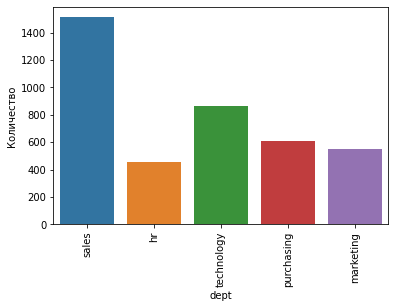

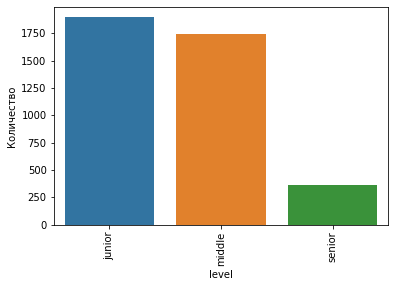

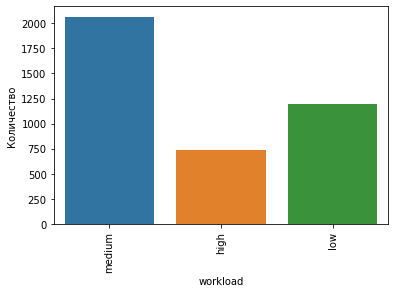

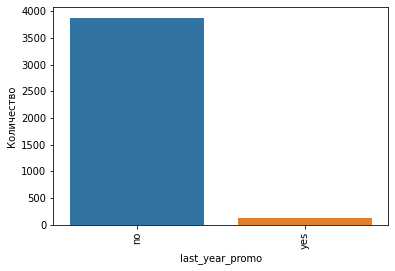

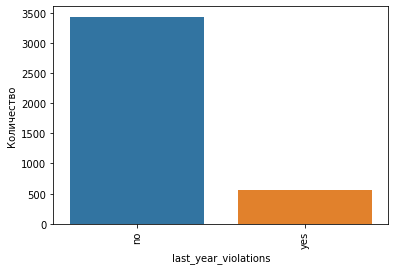

Гистограмма распределения значений для таблицы df_test_features


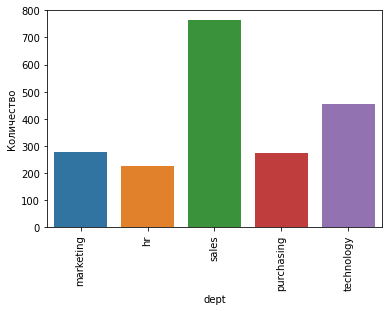

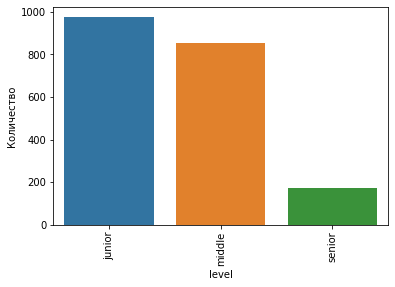

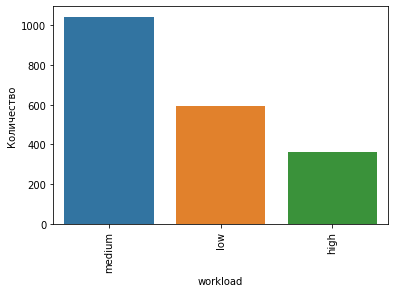

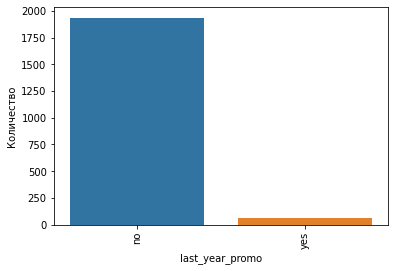

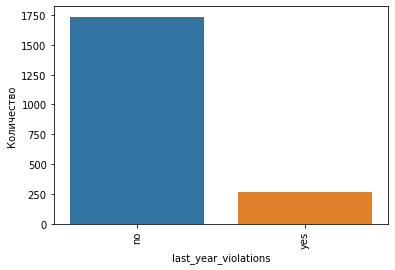

Гистограмма распределения значений для таблицы df_test_target_job_satisfaction_rate
Гистограмма распределения значений для таблицы df_train_quit


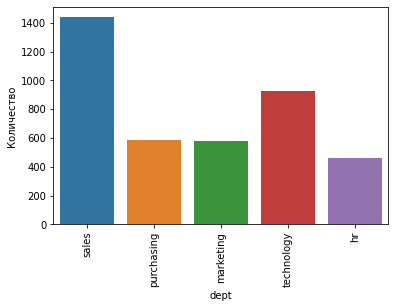

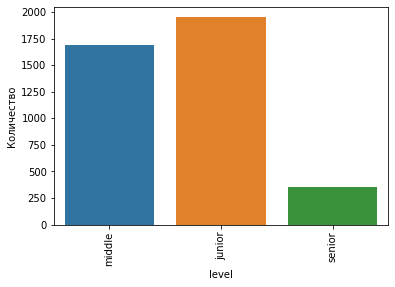

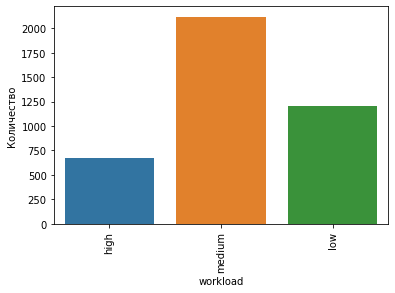

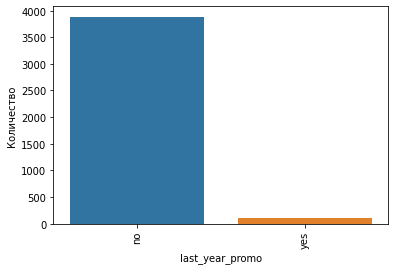

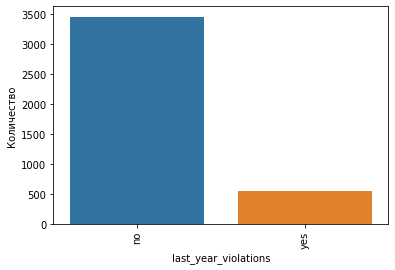

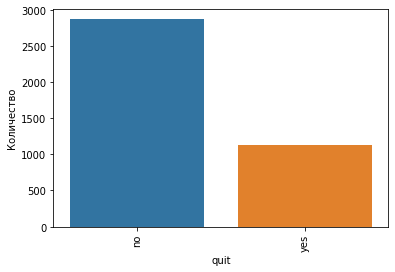

Гистограмма распределения значений для таблицы df_test_target_quit


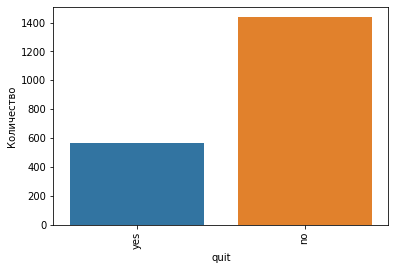

In [16]:
for f in DF_NAMES:
    print(f'Гистограмма распределения значений для таблицы {f}')
    for c in globals()['col_cat_' + f.strip('df_')]:
        ax = sns.countplot(x=c, data = globals()[f])
        ax.set(xlabel=c, ylabel='Количество')
        plt.xticks(rotation=90)
        plt.show()

Во многих признаках наблюдается дисбаланс классов, который придется устранять в пайплайне

#### 3.1.2 Построим графики количественных признаков

Построим для численных данных пару графиков: гистограмму и boxplot, кроме того, проверим распределения на нормальность с помощью shapiro и normaltest.

"Пара графиков для таблицы df_train_job_satisfaction_rate


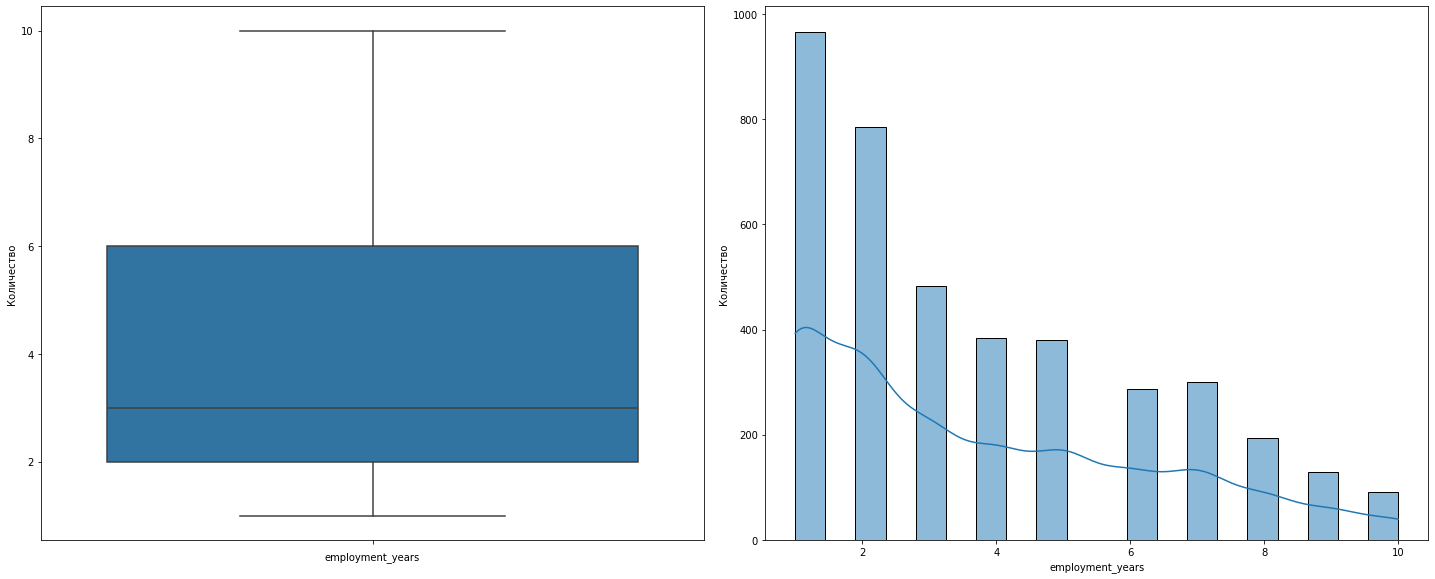

'stat=0.887, p=0.000\n'

Probably not Gaussian


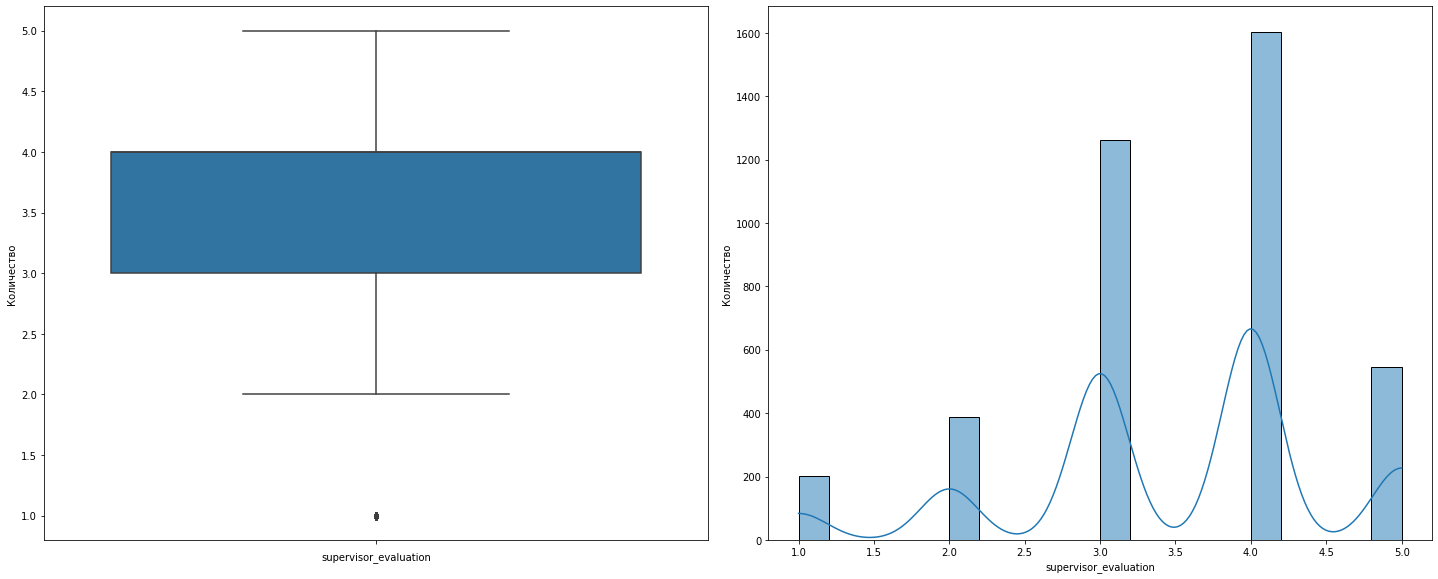

'stat=0.886, p=0.000\n'

Probably not Gaussian


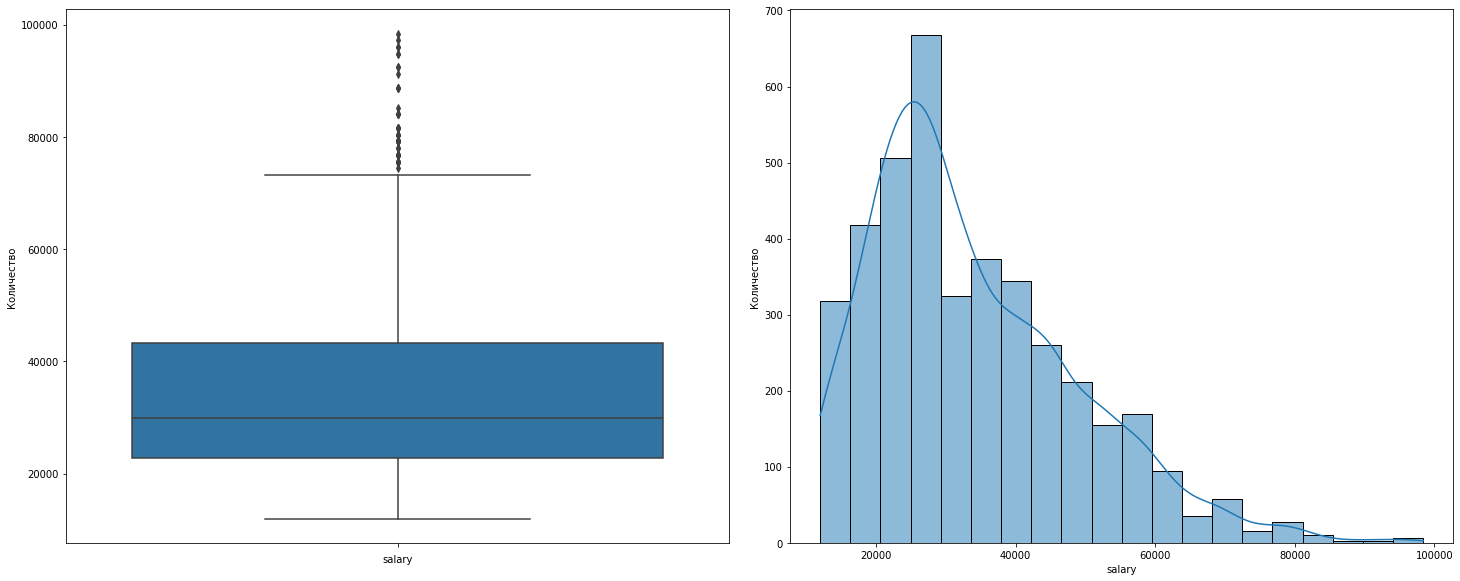

'stat=0.939, p=0.000\n'

Probably not Gaussian


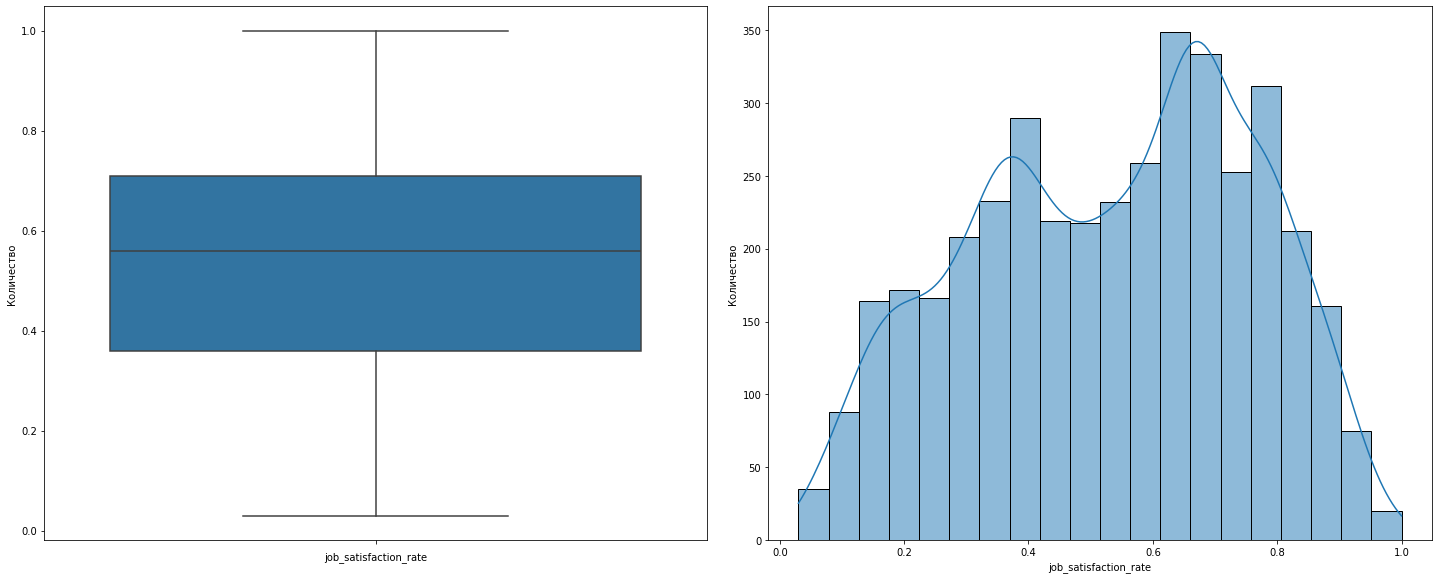

'stat=0.971, p=0.000\n'

Probably not Gaussian
"Пара графиков для таблицы df_test_features


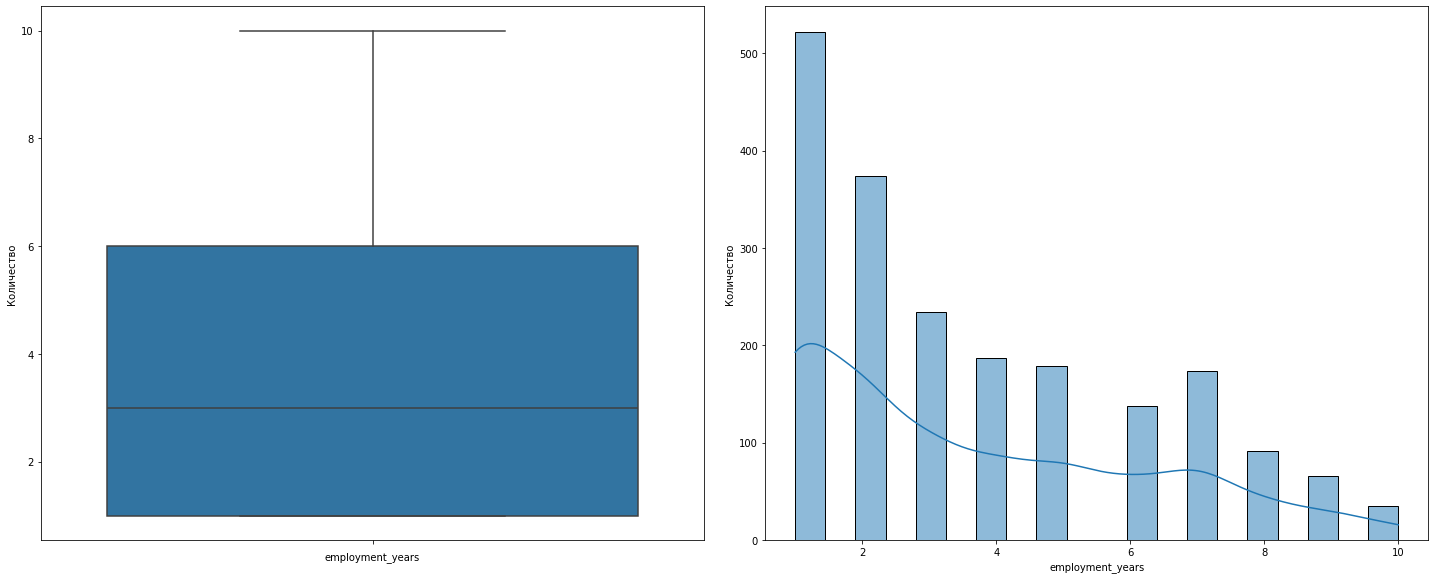

'stat=0.882, p=0.000\n'

Probably not Gaussian


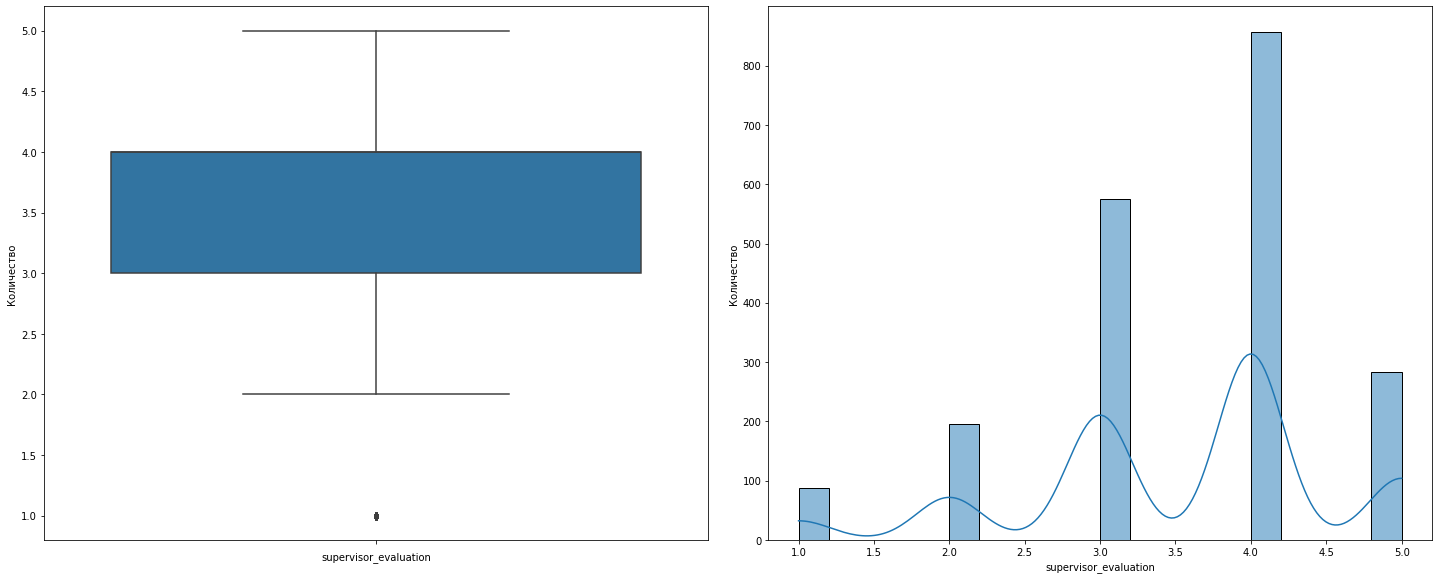

'stat=0.880, p=0.000\n'

Probably not Gaussian


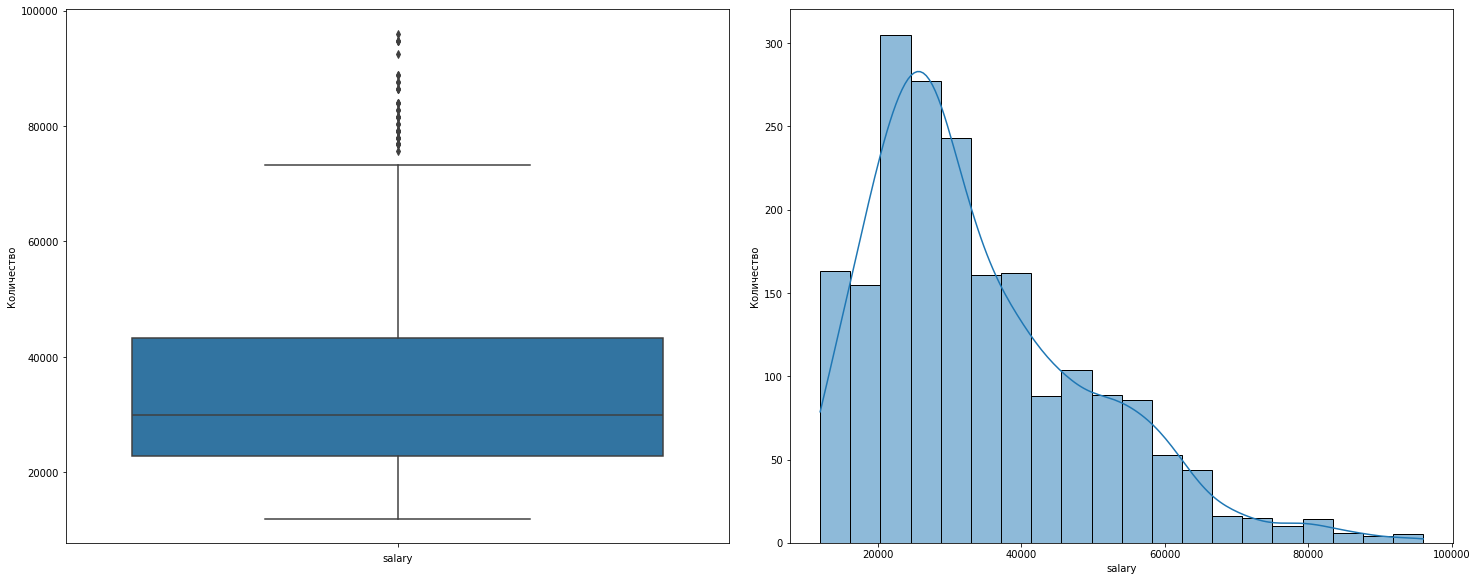

'stat=0.926, p=0.000\n'

Probably not Gaussian
"Пара графиков для таблицы df_test_target_job_satisfaction_rate


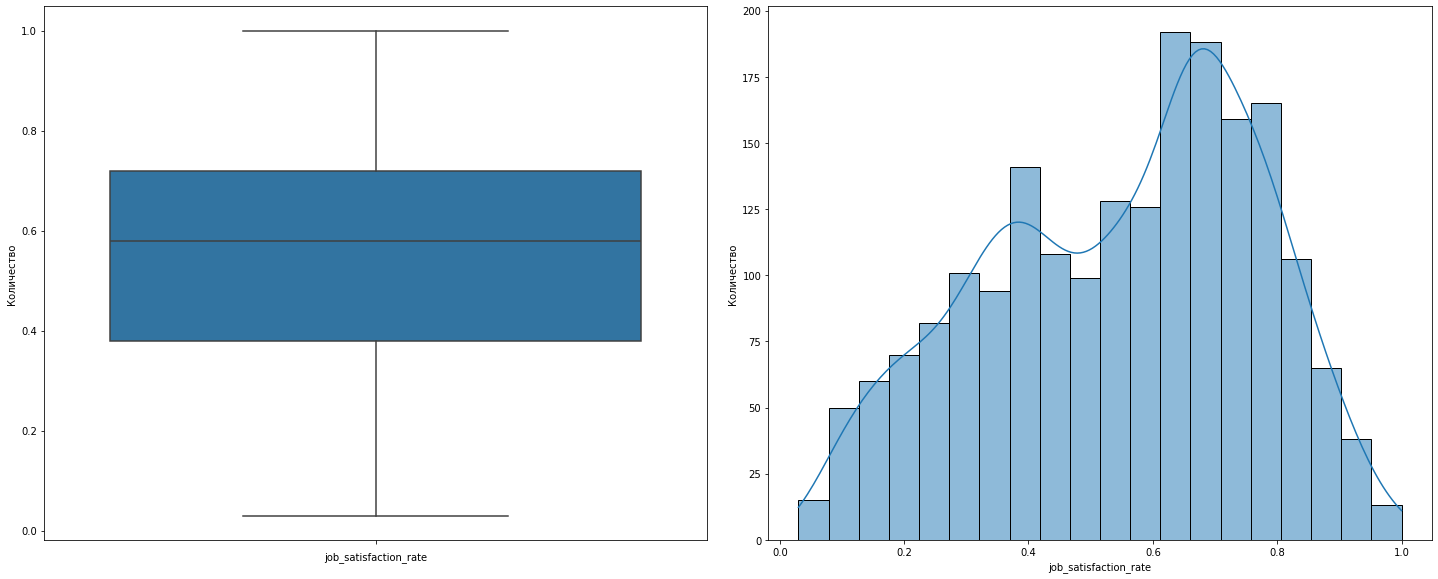

'stat=0.970, p=0.000\n'

Probably not Gaussian
"Пара графиков для таблицы df_train_quit


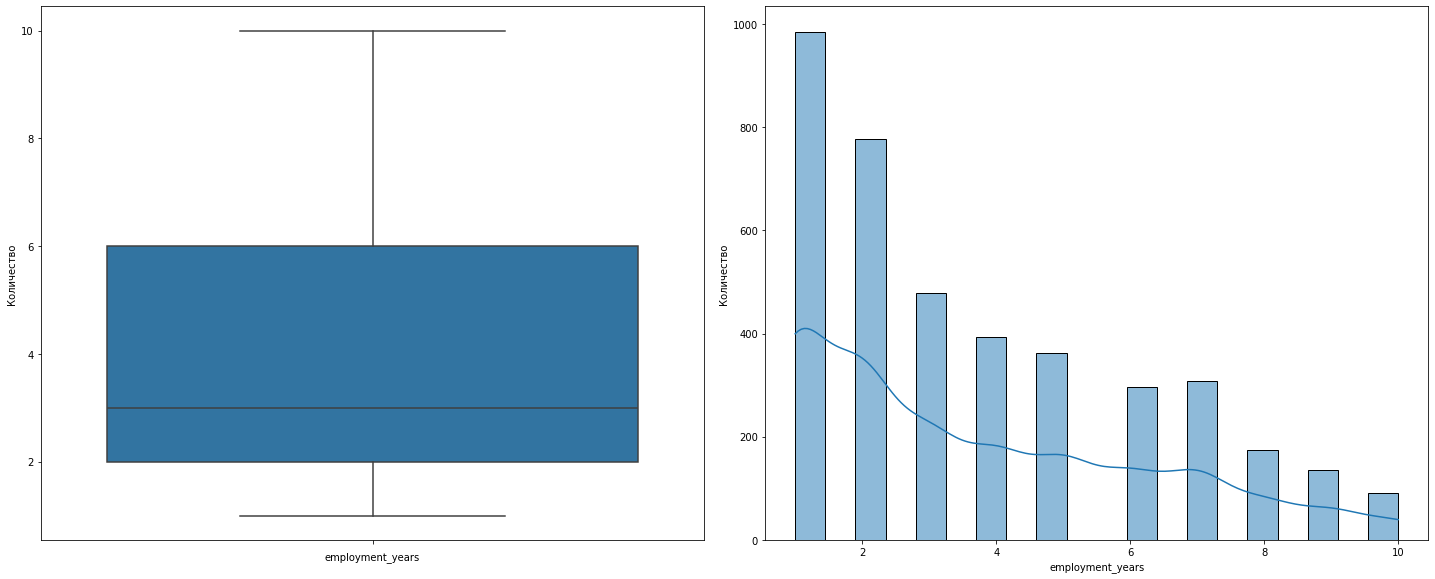

'stat=0.886, p=0.000\n'

Probably not Gaussian


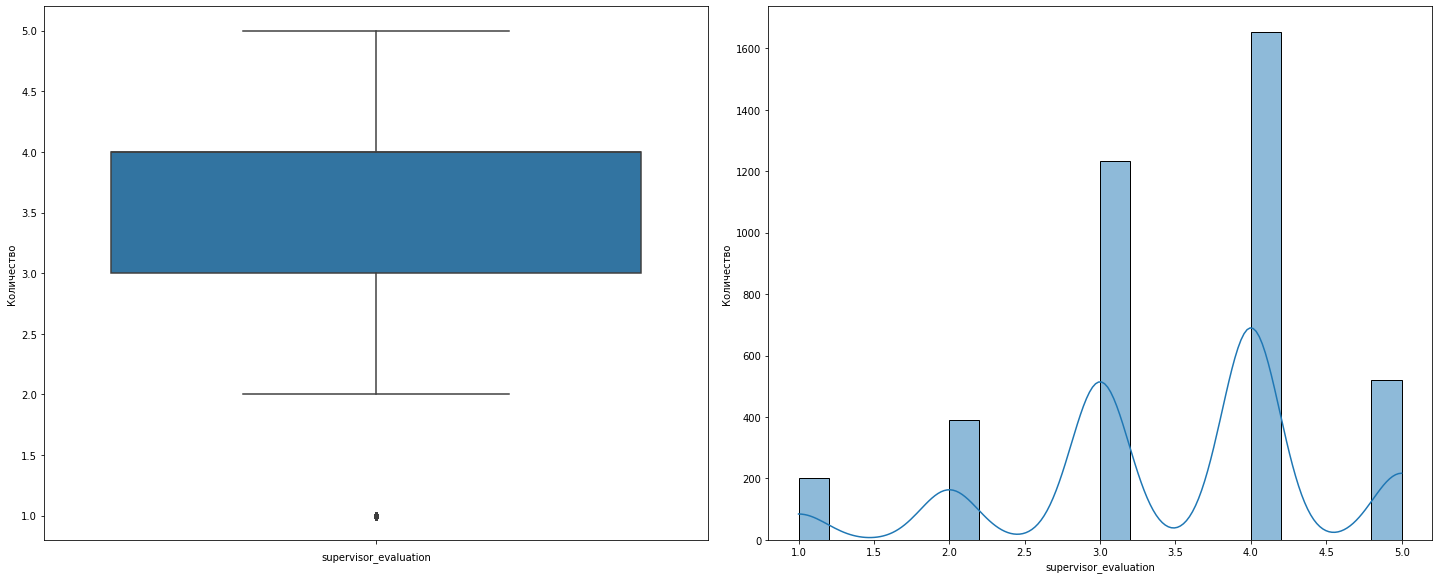

'stat=0.883, p=0.000\n'

Probably not Gaussian


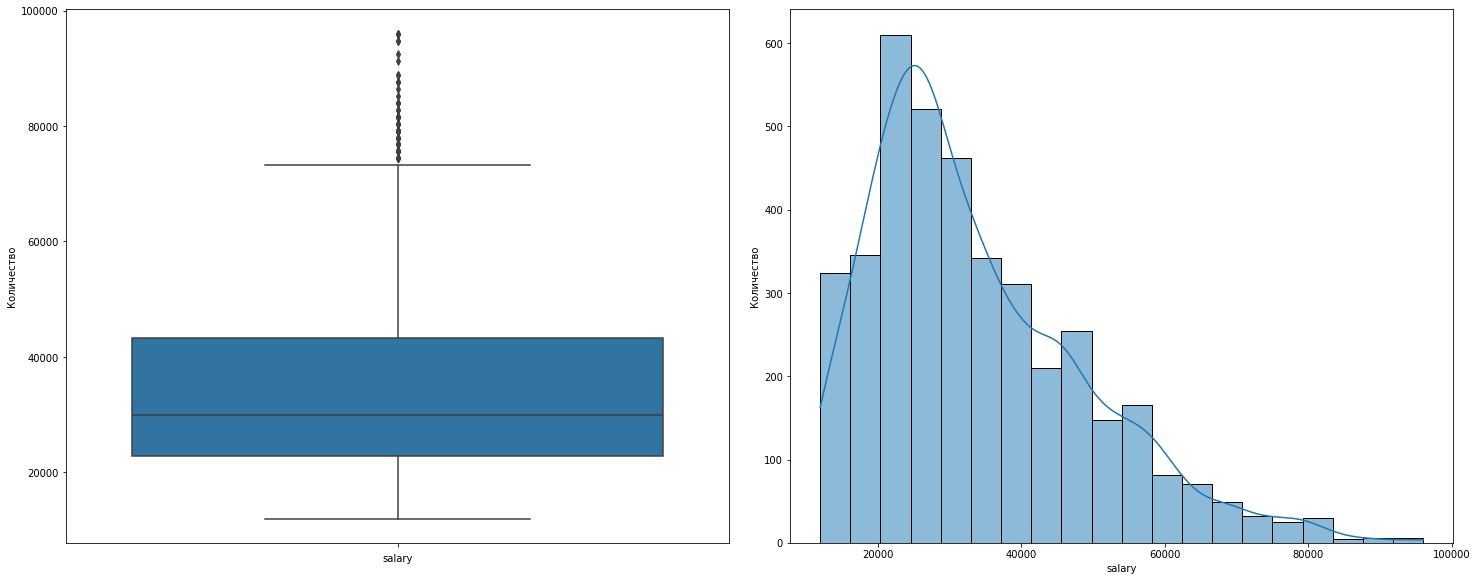

'stat=0.930, p=0.000\n'

Probably not Gaussian
"Пара графиков для таблицы df_test_target_quit


In [17]:
for f in DF_NAMES[:5]:
    print(f'"Пара графиков для таблицы {f}')
    for c in globals()['col_num_' + f.strip('df_')]:
        if c != 'id':
            fig, axes = plt.subplots(1,2, figsize=(20, 8), constrained_layout=False)
            fig.tight_layout(h_pad=10,w_pad=3)
            axes = axes.ravel()
            ax = sns.histplot(x=c, data = globals()[f], bins=20, kde=True)
            ax.set(xlabel=c, ylabel='Количество')
            ax = sns.boxplot(y=c, data=globals()[f], ax=axes[0])
            ax.set(xlabel=c, ylabel='Количество')
            plt.show()
            #print(kstest(globals()[f][c], 'norm'))

            stat, p = shapiro(globals()[f][c])
            display('stat=%.3f, p=%.3f\n' % (stat, p))
            #print(stat, p)
            if p > 0.05:
                print('Probably Gaussian')
            else:
                print('Probably not Gaussian')

'Из тренировочной выборки:'

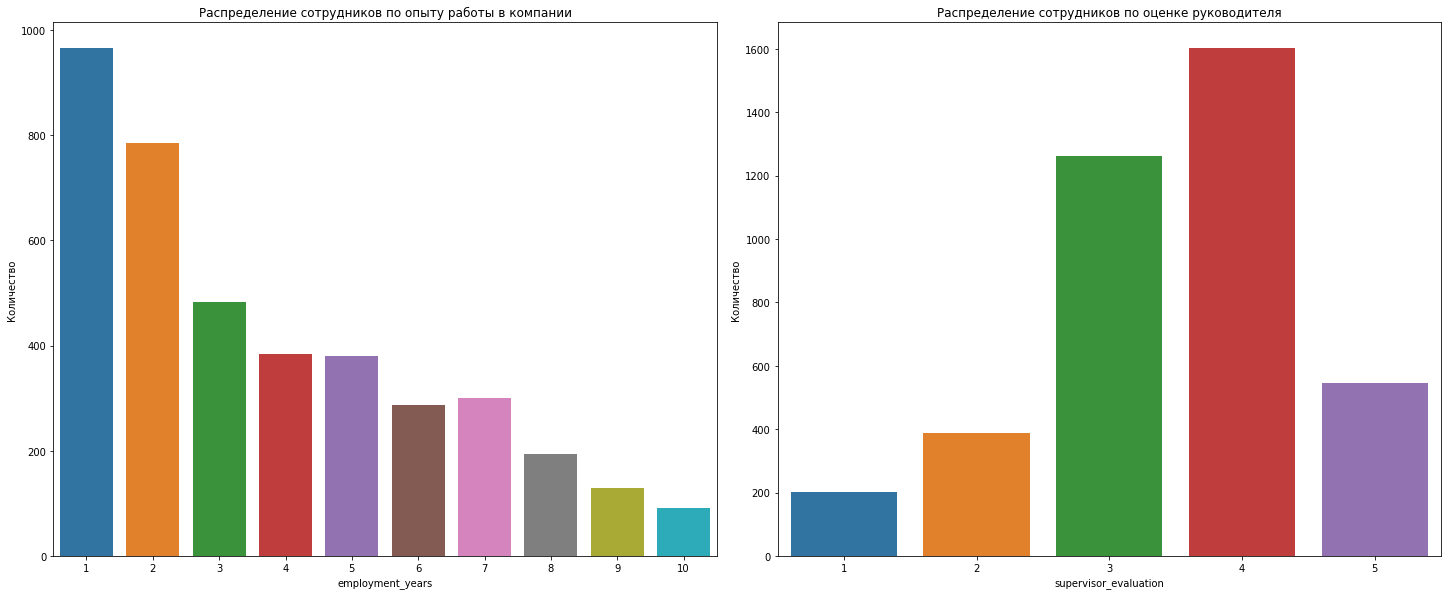

In [18]:
display('Из тренировочной выборки:')
fig, axes = plt.subplots(1,2, figsize=(20, 8), constrained_layout=False)
fig.tight_layout(h_pad=10,w_pad=3)
axes = axes.ravel()
ax = sns.countplot(data=df_train_job_satisfaction_rate, x= 'employment_years', ax=axes[0])
ax.set(title='Распределение сотрудников по опыту работы в компании', xlabel='employment_years', ylabel='Количество')
ax1 = sns.countplot(data=df_train_job_satisfaction_rate, x= 'supervisor_evaluation')
ax1.set(title='Распределение сотрудников по оценке руководителя', xlabel='supervisor_evaluation', ylabel='Количество')
plt.show()


'Из тестовой выборки:'

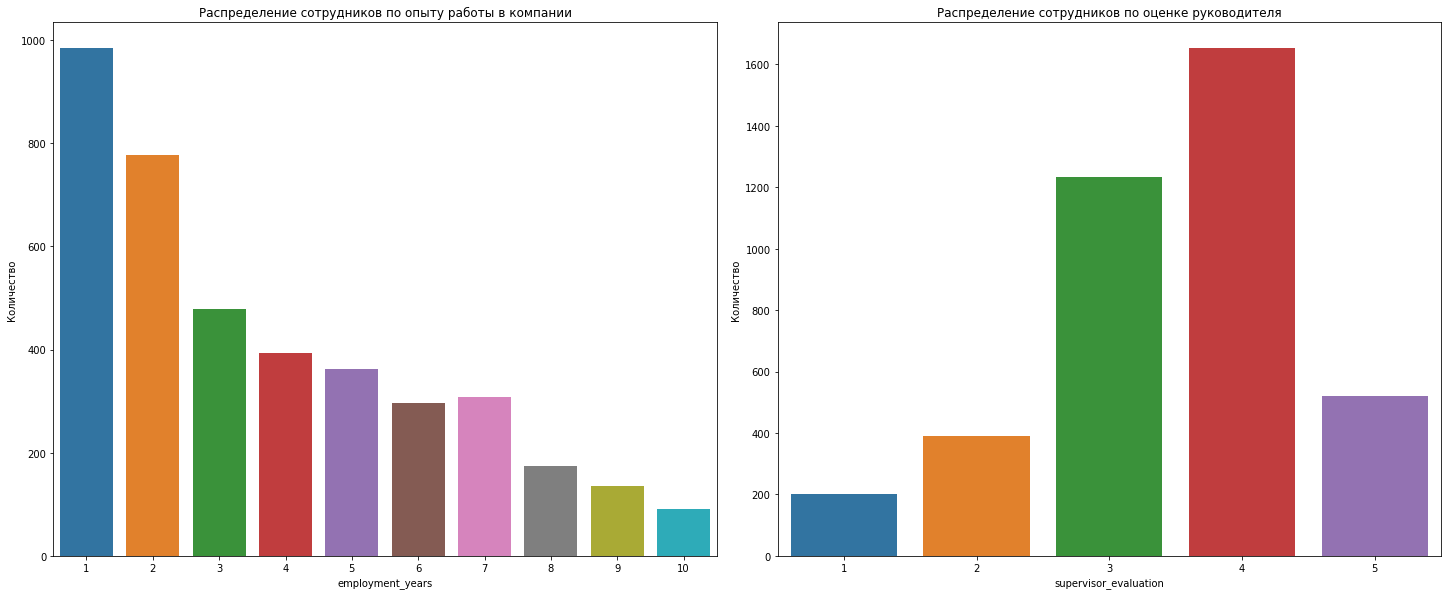

In [19]:
display('Из тестовой выборки:')
fig, axes = plt.subplots(1,2, figsize=(20, 8), constrained_layout=False)
fig.tight_layout(h_pad=10,w_pad=3)
axes = axes.ravel()
ax = sns.countplot(data=df_train_quit, x= 'employment_years', ax=axes[0])
ax.set(title='Распределение сотрудников по опыту работы в компании', xlabel='employment_years', ylabel='Количество')
ax1 = sns.countplot(data=df_train_quit, x= 'supervisor_evaluation')
ax1.set(title='Распределение сотрудников по оценке руководителя', xlabel='supervisor_evaluation', ylabel='Количество')
plt.show()

Выводы:
1. Ни для одного из признаков распределение не является нормальным, поэтому при корреляционном анализе нам будет необходимо отказаться от стандартной корреляции Пирсона, а использовать другие подходы, устойчивые к выбросам и ненормальному распределению, например phik.
2. У признака supervisor_evaluation eсть выбросы в нижней части боксплота - очевидно, есть сотрудники с аномально низкими оценками.
3. Среди распределения зарплат также есть нестандартно высокие значения, формально считающиеся выбросами.

#### 3.1.3 Построим матрицу phik для тренировочного датасета

удалим 'employment_years' и 'supervisor_evaluation' из списка interval_cols:

In [20]:
#display(interval_cols)
for i in interval_cols:
    try:
        i.remove('employment_years')
        i.remove('supervisor_evaluation')
        #i.remove('id')
    except ValueError:
        pass
interval_cols

[['salary', 'job_satisfaction_rate'],
 ['salary'],
 ['job_satisfaction_rate'],
 ['salary'],
 []]

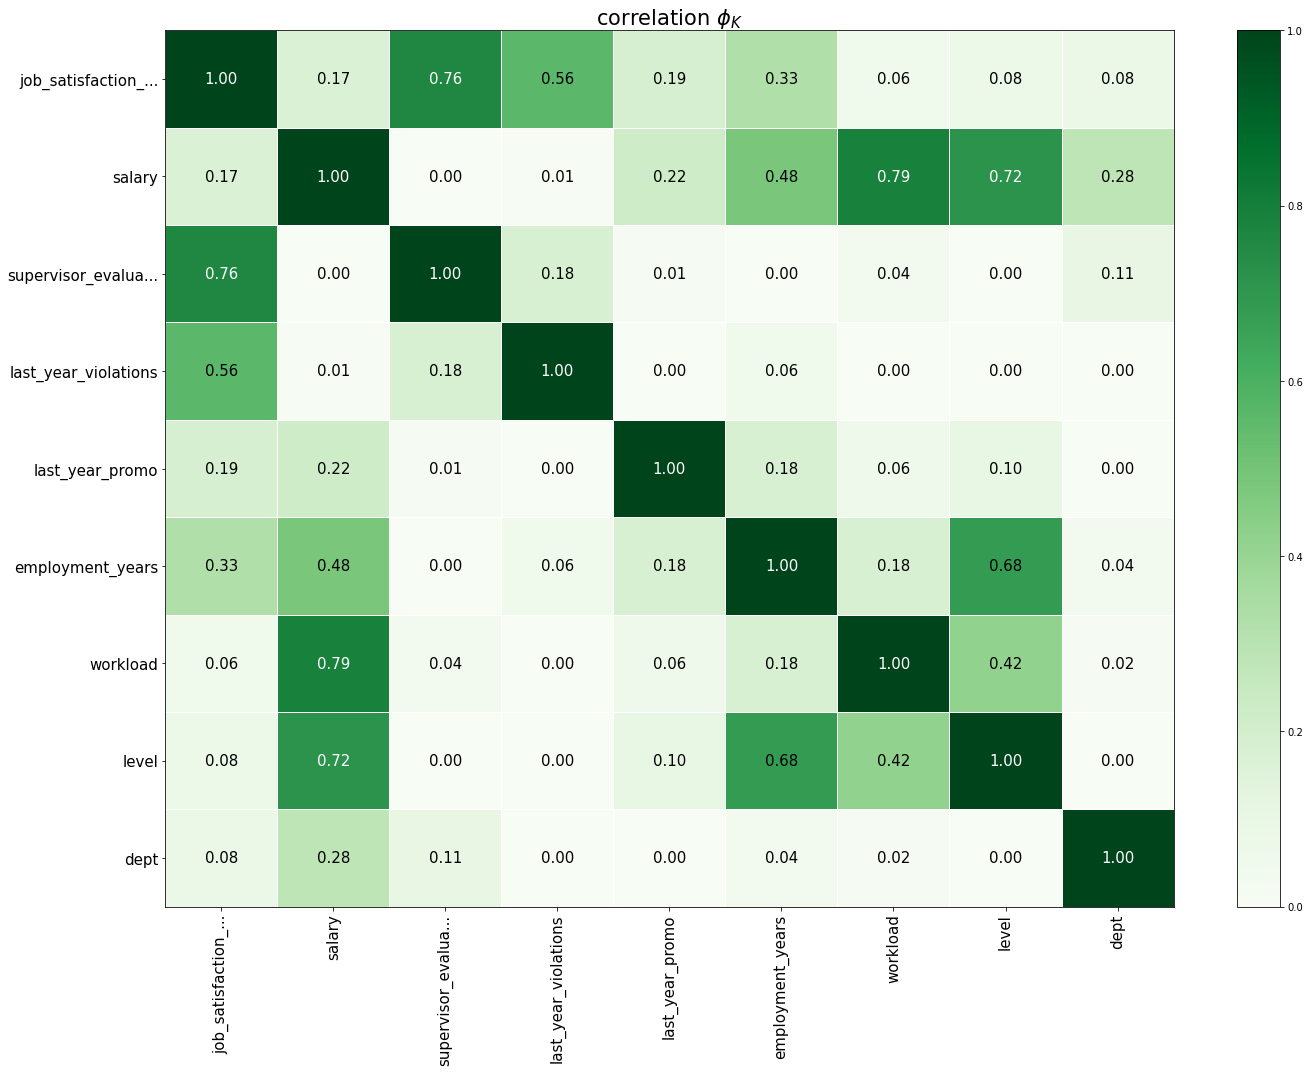

In [21]:

# считаем корреляции
phik_overview = phik_matrix(df_train_job_satisfaction_rate, interval_cols=interval_cols[0]) #.drop('id', axis =1), interval_cols=interval_cols[0])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Самые важные признаки, влияющие на целевой:
1. supervisor_evaluation.
2. last_year_violations.
3. employment_years.

Эти три признака оказывают значительное влияние на целевой, возможна проблема переобучения (посмотрим позже).

In [22]:
OHE_COLUMNS = ['dept', 'last_year_promo', 'last_year_violations']
ORD_COLUMNS = ['level', 'workload']
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary']

Построим диаграмму рассеяния зависимости целевого признака от остальных на тренировочной выборке.

In [23]:
df_train_job_satisfaction_rate['job_satisfaction_rate'].unique()

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

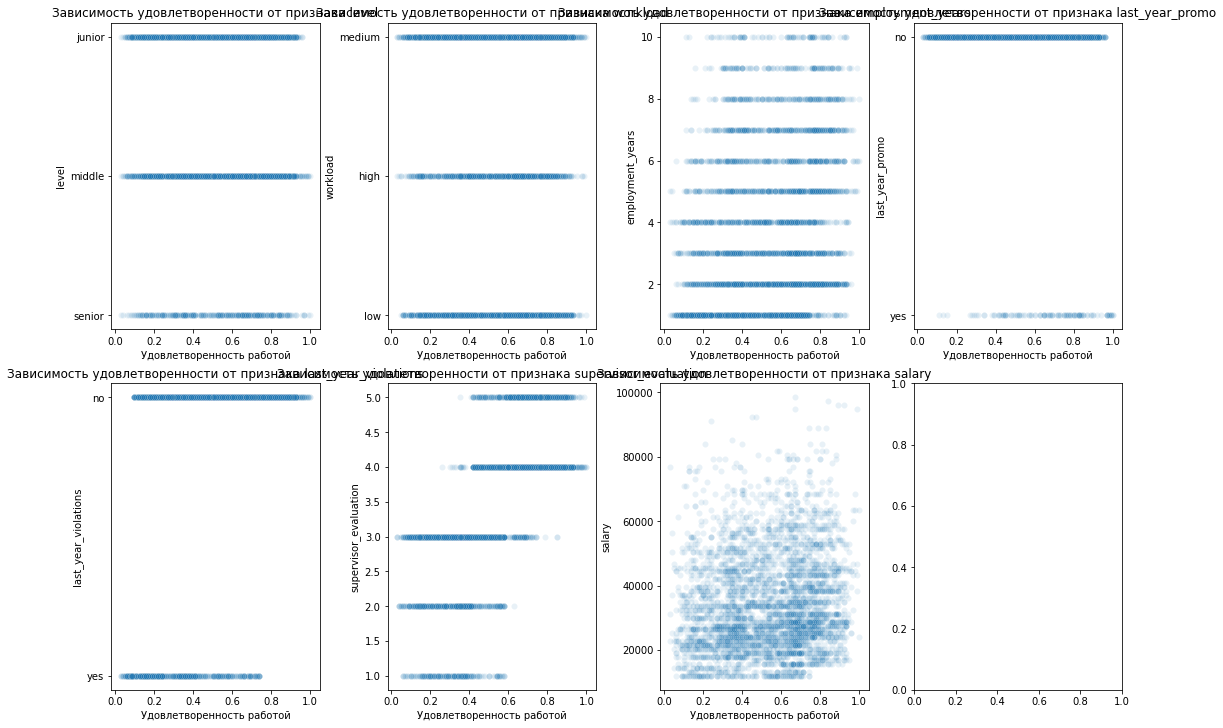

In [24]:
x=0
fig, axes = plt.subplots(2,4, figsize=(15, 10), constrained_layout=True)
#fig.tight_layout(h_pad=10,w_pad=2)
axes = axes.ravel()
for col in df_train_job_satisfaction_rate.columns.to_list()[1:-1]:
    ax = sns.scatterplot(data=df_train_job_satisfaction_rate, y= col, x='job_satisfaction_rate', ax=axes[x], alpha=0.1)
    ax.set(xlabel='Удовлетворенность работой', ylabel=col, title=('Зависимость удовлетворенности от признака ' + col))
    x+=1

Вывод: налицо дисбаланс классов входящих признаков.

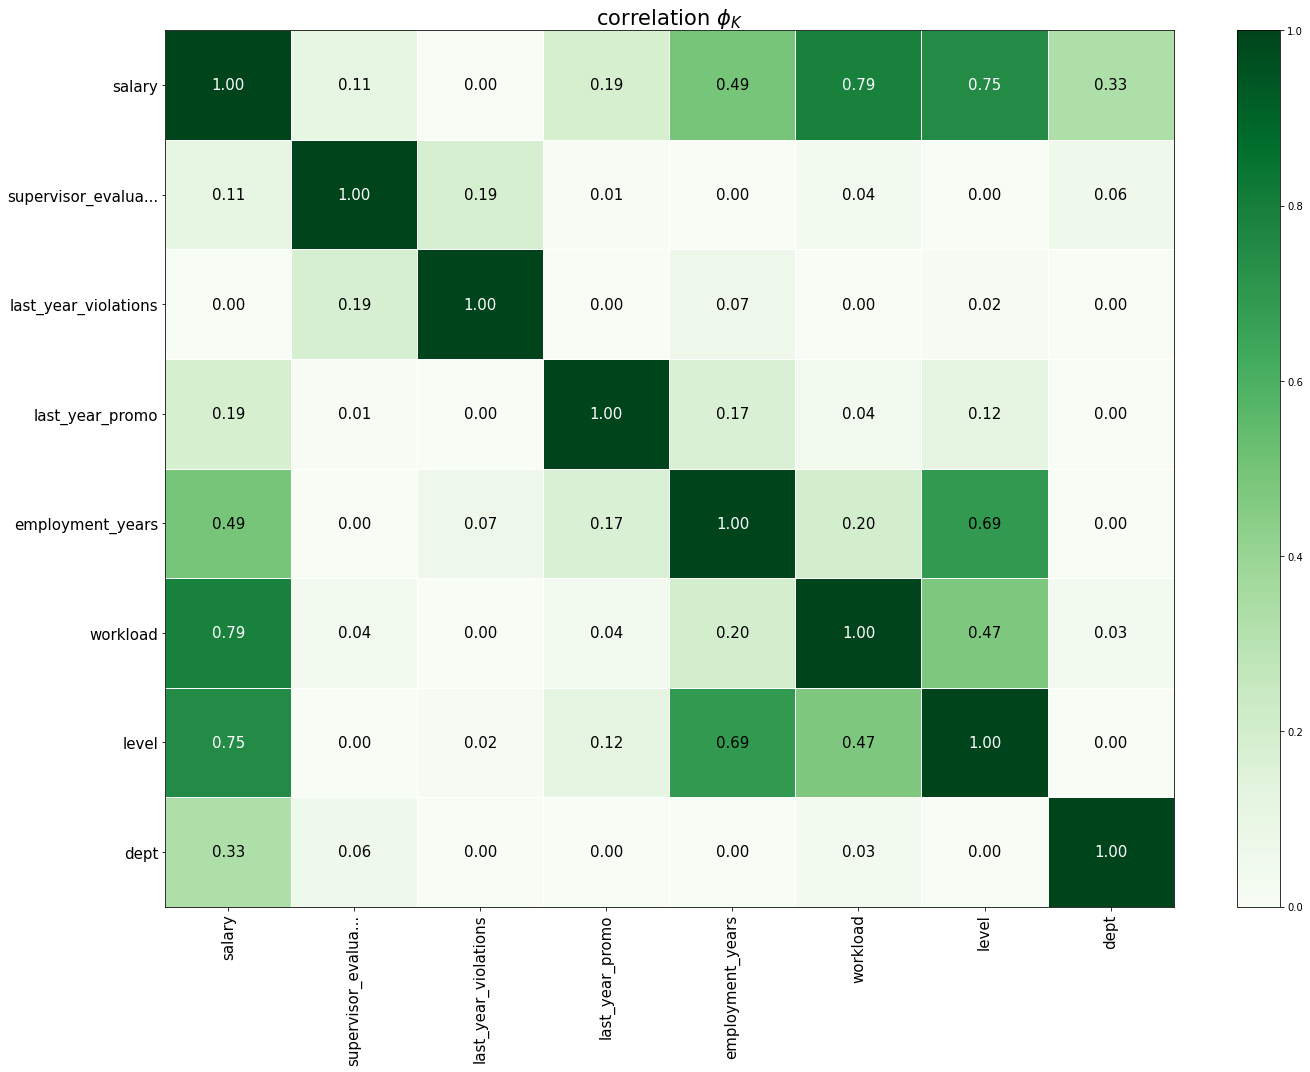

In [25]:
phik_overview = phik_matrix(df_test_features,  interval_cols=interval_cols[0])   #.drop('id', axis =1), interval_cols=interval_cols[0])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)


Существенных различий в данных в части распределений признаков нет. 


## 4. Подготовка данных.

### 4.1 Соединение таблиц

Т.к. тестовые признаки и таргет даны в двух разных файлах, то порядок в них может отличаться, т.е признаки из первой строки могут не соответствовать таргету из первой строки. Проверим.

In [26]:
df_test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [27]:
df_test_target_job_satisfaction_rate.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


id первых строк отличаются, поэтому нужно соединить 2 таблицы по id, чтобы все строки соответствовали друг другу:

In [28]:
df_test = df_test_features.merge(df_test_target_job_satisfaction_rate, on = 'id', how = 'left')

In [29]:
display(df_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


### 4.2 Подготовка пайплайна

In [30]:
X_train = df_train_job_satisfaction_rate #.drop(['id'], axis = 1)
X_test = df_test #.drop(['id'], axis = 1)
display(X_train.duplicated().sum())
X_train = X_train.drop_duplicates()
X_train.info()

245

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


In [31]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis = 1)
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate'] * 100
y_train = y_train.astype({'job_satisfaction_rate': int})
X_test = df_test.drop(['job_satisfaction_rate'], axis = 1)
y_test = df_test['job_satisfaction_rate']* 100
y_test = y_test.astype({'job_satisfaction_rate': int})

id и дубликаты удалил (выше)


In [32]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))#, sparse=False))
    ]
    )

In [33]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


In [34]:
# создаём общий препроцессор для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, OHE_COLUMNS),
     ('ord', ord_pipe, ORD_COLUMNS),
     ('num', StandardScaler(), NUM_COLUMNS)
    ],
    remainder='passthrough'
)

In [35]:
# объявим словарь гиперпараметров моделей
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,300),  #[None] + [i for i in range(2, 7)]
        'models__min_samples_leaf': [2, 3 , 4, 5, 6, 7],
        'models__min_samples_split': [2, 4, 6],
        'models__max_leaf_nodes': range(2,300),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            #solver='liblinear',
            penalty='l2', # пробуем отбор признаков l2-регуляризацией
            class_weight='balanced',
            C=2,
            solver='saga'
        )],
        'models__C': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

## 5. Обучение моделей

In [36]:
# делаем свою метрику
smape_score = make_scorer(smape, greater_is_better=False)
display(smape_score)

make_scorer(smape, greater_is_better=False, response_method='predict')

In [37]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


In [38]:
# определим автоматический поиск моделей через
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    scoring=smape_score,
    cv=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [39]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'models__n_neighbors': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(C=2,
                                                                       class_weight='balanced',
                                                                       random_state=42,
                                                                       solver='saga')],
                                         'models__C': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [40]:
print("\n Лучшая модель:\n", randomized_search.best_estimator_)
print(f'\n Лучший результат метрики по всем гиперпараметрам: {np.abs((randomized_search.best_score_)):.2f}')
print(f'\n Лучшие параметры среди всех гиперпараметров:\n {randomized_search.best_params_}')


 Лучшая модель:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                 

In [41]:
print(f'\n Метрика SMAPE на тестовой выборке: {smape(y_test, randomized_search.predict(X_test)):.2f}')


 Метрика SMAPE на тестовой выборке: 13.38


Лучшей оказалась модель DecisionTreeRegressor, т.к. она позволяет более гибко настроить параметры поиска лучшей модели: настроить глубину, макс. кол-во узлов, мин. кол-во выборок для разделения узла, мин. кол-во выборок на листе.

In [42]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, randomized_search.predict(X_test)):.2f}')
#display(y_test_pred)
display(X_test.head())

Метрика SMAPE на тестовой выборке: 13.38


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


## 6. Задача 2

### 6.1 Предобработка данных

соединим таблицы тестовых признаков с целевым (уволился/нет)

In [43]:
df_quit_test = df_test_features.merge(df_test_target_quit, on = 'id', how = 'left')
display(df_quit_test.sample(5))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
372985,sales,middle,medium,3,yes,no,3,42000,no
385312,sales,junior,medium,1,no,no,3,20400,yes
938867,sales,middle,high,6,no,no,4,54000,no
866432,sales,junior,low,2,no,no,4,15600,no
715588,hr,junior,low,4,no,no,1,19200,no


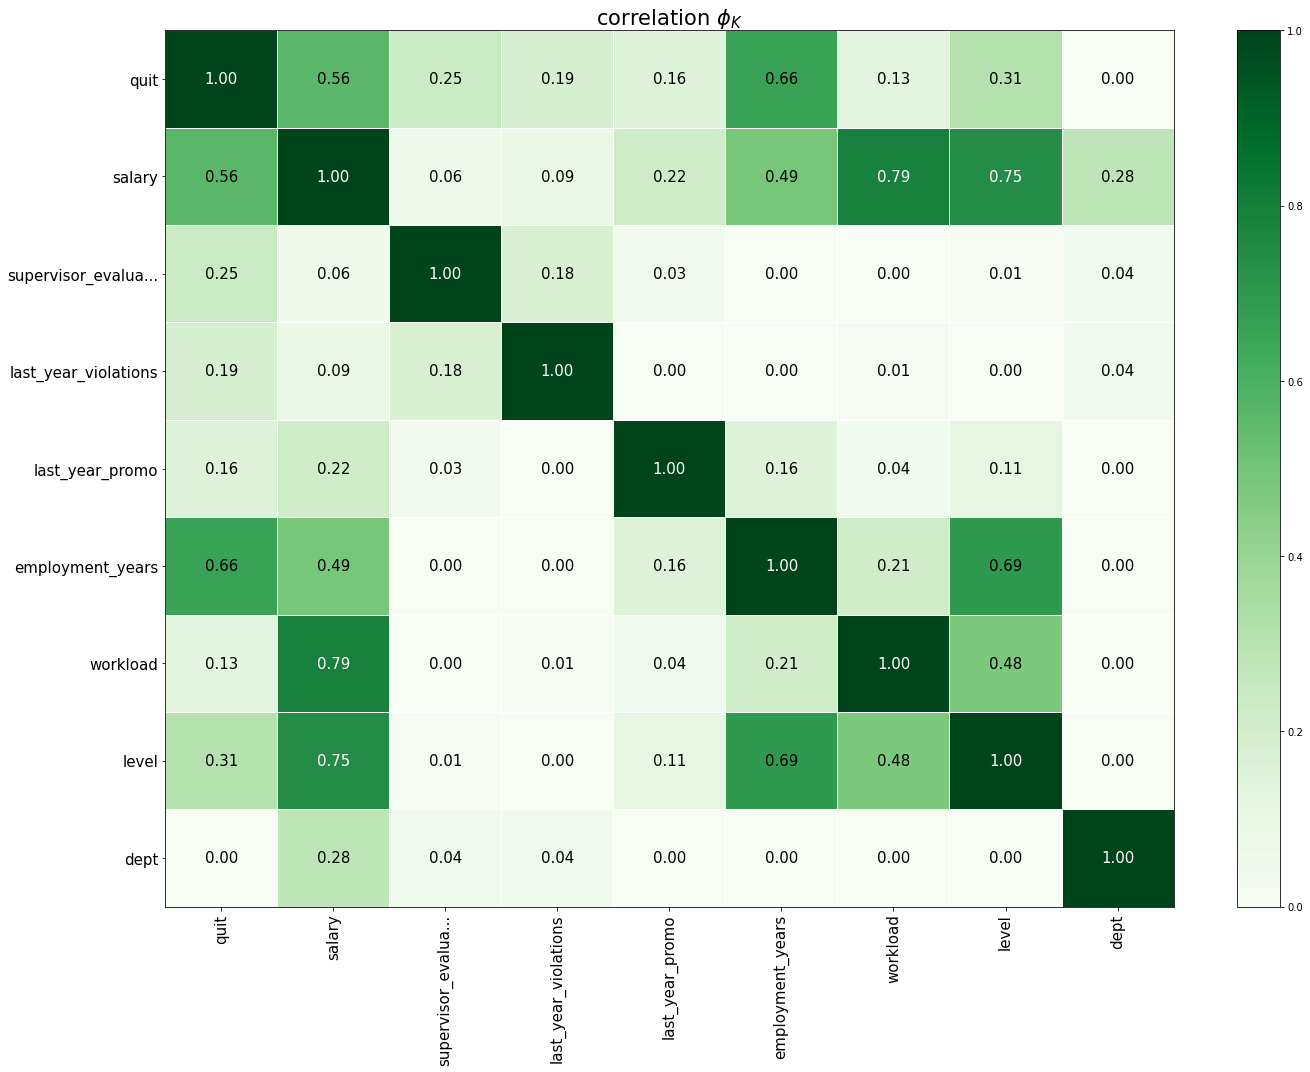

In [44]:
phik_overview = phik_matrix(df_train_quit, interval_cols=interval_cols[0])   #.drop('id', axis =1), interval_cols=interval_cols[0])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

наиболее важными признаками, влияющими на целевой на этот раз являются:
1. employment_years. (кол-во лет в компании),
2. salary (зп),
3. level (уровень квалификации).
</div> 

### 6.2 Составим портрет «уволившегося сотрудника».

Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

In [45]:
df_train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

In [46]:
display(df_train_job_satisfaction_rate.columns)
display(df_train_quit.columns)


Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'],
      dtype='object')

In [47]:
df_quitted = df_train_quit[df_train_quit['quit'] == 'yes']
df_quitted.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
257132,sales,junior,medium,2,no,yes,3,24000,yes
699916,sales,junior,low,1,no,yes,3,18000,yes
613206,technology,middle,medium,2,no,no,3,45600,yes
468145,technology,junior,medium,2,no,no,3,30000,yes
982346,marketing,junior,medium,3,no,no,3,30000,yes


['level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary']

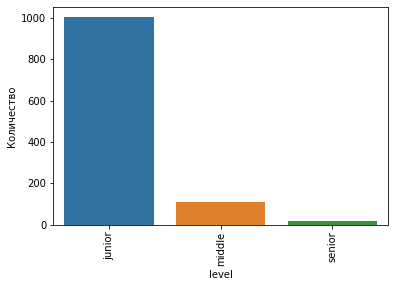

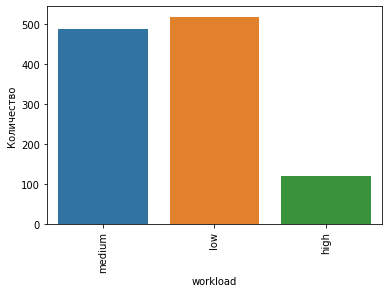

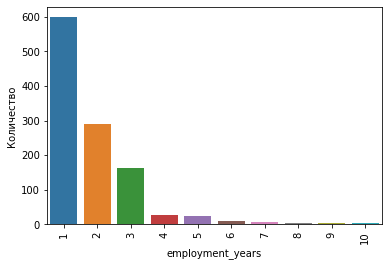

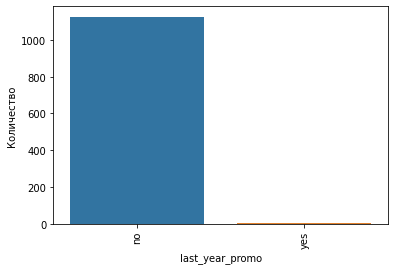

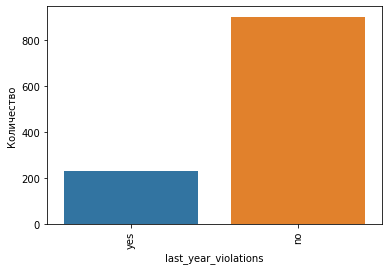

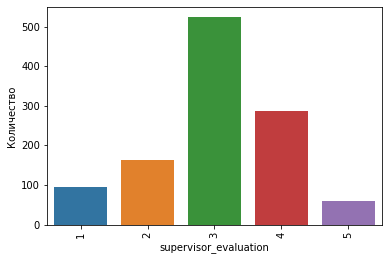

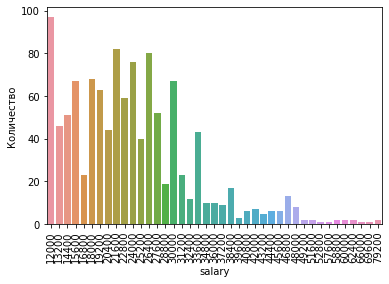

In [48]:
    #делаем список солонок без id
    col = df_quitted.columns.tolist()[1:8]
    display(col)
    #a = df_quitted['dept'].value_counts(normalize=True)
    #display(a)
    # строим гистограммы по уволенным сотрудникам
    for c in col:
        ax = sns.countplot(x=c, data = df_quitted)
        ax.set(xlabel=c, ylabel='Количество')
        plt.xticks(rotation=90)
        plt.show()

Также сравним среднее значение зарплаты ушедших сотрудников со средней зп оставшихся:

In [49]:
display('средняя зп уволившихся сотрудников:', df_quitted['salary'].mean())

'средняя зп уволившихся сотрудников:'

23885.106382978724

In [50]:
display('средняя зп оставшихся сотрудников:', df_train_quit[df_train_quit['quit']=='no']['salary'].mean())

'средняя зп оставшихся сотрудников:'

37702.22841225627

Итак, портрет уволившегося сотрудника:
1. Он чаще всего - бывший работник отдела продаж либо технологического отдела.
2. В подавляющем большинстве случаев - это джуниор, с небольшой или средней загруженностью.
3. Скроее всего уволился в течение первых трех лет работы (чаще всего - в первый же год, с течением времени (полсе 3-х лет) вероятность увольнения резко уменьшается).
4. Не имел повышений в течение последнего года работы (но с бОльшей вероятностью не имел и нарушений трудового договора).
5. Чаще всего увольняется "троечник", на втором месте "хорошист" - с точки зрения руководителя.
6. Кроме того, средняя зп уволившегося сотрудника почти в 2 раза меньше средней зп оставшихся.

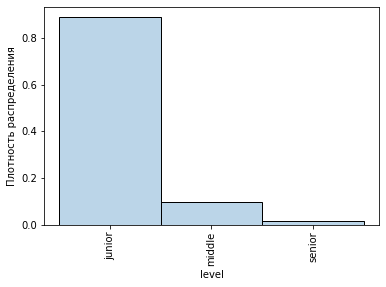

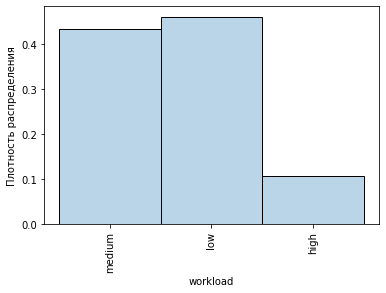

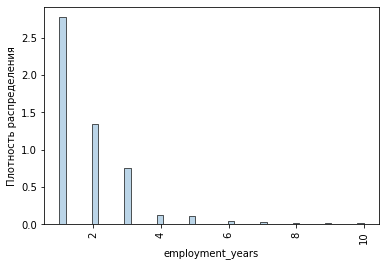

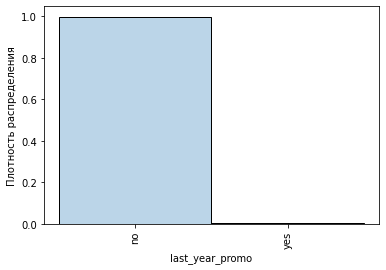

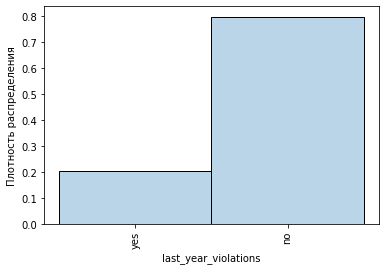

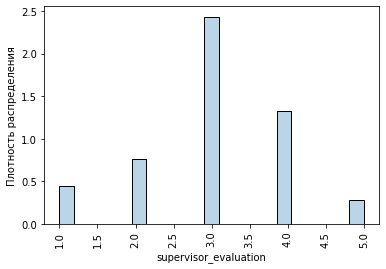

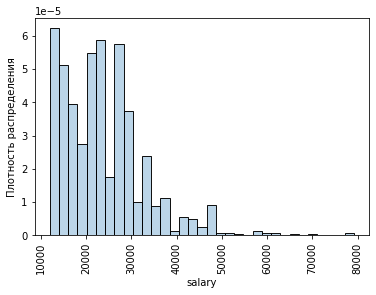

In [51]:


# строим гистограммы по уволенным сотрудникам
for c in col:
    ax = sns.histplot(
    x=c, data = df_quitted, alpha = 0.3, #, color='green',
    stat='density', common_norm=True
)
    #ax = sns.countplot(x=c, data = df_quitted value_counts(normalize=True))
    ax.set(xlabel=c, ylabel='Плотность распределения')
    plt.xticks(rotation=90)
    plt.show()


Выводы - те же.


### 6.3 Визуализация распределения признака job_satisfaction_rate

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

Для этого для начала добавим целевой признак job_satisfaction_rate в датафрейм df_quit_test

In [52]:
df_quit_test_jsr = df_quit_test.merge(df_test_target_job_satisfaction_rate, on = 'id', how = 'left')
display(df_quit_test_jsr.sample(5))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
855998,sales,junior,medium,1,no,no,5,25200,no,0.67
607712,purchasing,middle,medium,8,no,no,2,32400,no,0.25
923073,purchasing,junior,medium,2,no,no,5,25200,no,0.93
900757,sales,middle,low,3,no,no,1,22800,no,0.20
761388,sales,middle,medium,4,no,no,5,43200,no,0.67


In [53]:
# Сравнение двух групп данных
group_comparison = df_quit_test_jsr.groupby('quit').describe()
display(group_comparison)

employment_years                                                \
                count      mean       std  min  25%  50%  75%   max   
quit                                                                  
no             1436.0  4.330780  2.540800  1.0  2.0  4.0  6.0  10.0   
yes             564.0  1.975177  1.552888  1.0  1.0  1.0  2.0  10.0   

     supervisor_evaluation            ...   salary           \
                     count      mean  ...      75%      max   
quit                                  ...                     
no                  1436.0  3.716574  ...  48000.0  96000.0   
yes                  564.0  3.042553  ...  30000.0  80400.0   

     job_satisfaction_rate                                                      
                     count      mean       std   min   25%   50%     75%   max  
quit                                                                            
no                  1436.0  0.612040  0.199367  0.03  0.50  0.66  0.7600  1.00  
yes                  564.0  0.387713  0.185784  0.04  0.24  0.37  0.4925  0.97  

[2 rows x 32 columns]

теперь переведем целевой признак quit в бинарный вид, чтобы можно было строить диаграмму рассеяния

In [54]:
t = 'yes'
df_quit_test_jsr['quit'] = df_quit_test_jsr['quit'].apply(lambda x: 1 if x == t else 0)

на графике видно, что гораздо чаще уходят  менее удовлетворенные сотрудники, более удовлетворенные - остаются в компании.

In [55]:
df_quit_test_jsr['quit'].unique()

array([0, 1])



добавил нормализацию:


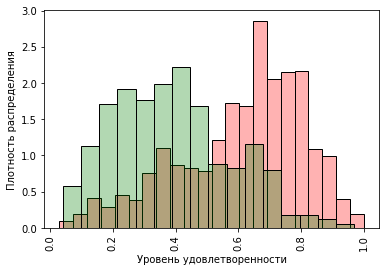

In [56]:

ax = sns.histplot(
    x='job_satisfaction_rate', data = df_quit_test_jsr[df_quit_test_jsr['quit']== 0], alpha = 0.3, color='red',
    stat='density', common_norm=False
)
ax = sns.histplot(x='job_satisfaction_rate', data = df_quit_test_jsr[df_quit_test_jsr['quit']== 1], alpha =0.3, color = 'green',
    stat='density', common_norm=False
)
ax.set(xlabel='Уровень удовлетворенности', ylabel='Плотность распределения')
plt.xticks(rotation=90)
plt.show()



из графика видно, что уволившиеся сотрудники (помечены зеленым) в целом гораздо менее удовлетворены работой.


## 7. Добавление нового входного признака

Учитывая, что job_satisfaction_rate и quit действительно связаны, добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [57]:
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


предскажем job_satisfaction_rate на данных df_train_quit с помощью лучшей модели:

In [58]:
y_test_pred_2 = randomized_search.predict(df_train_quit)


### 7.1 Добавим эти предсказания к входным признакам второй задачи

In [59]:
df_train_quit['jsr_pred'] = y_test_pred_2 # это наш X_train по второй задаче
display(df_train_quit.sample(5))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,jsr_pred
id,,,,,,,,,,
600907,sales,junior,medium,2,no,no,3,27600,no,52.272727
273482,technology,middle,medium,2,no,no,3,49200,no,35.111111
852537,technology,junior,high,2,no,yes,4,38400,yes,65.108108
125627,hr,junior,low,2,no,no,4,13200,yes,66.040816
130141,sales,junior,low,3,no,no,4,15600,no,80.263158


In [60]:

#df_quit_test['jsr_pred']= y_test_pred # т.е. вставляем в тест. выборку результат предсказаний на тестовых данных
                                            # это будет наш новый X_test
df_quit_test['jsr_pred'] = randomized_search.predict(df_test_features)
display(df_quit_test)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,jsr_pred
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,82.400000
686555,hr,junior,medium,1,no,no,4,30000,no,66.794118
467458,sales,middle,low,5,no,no,4,19200,no,65.222222
418655,sales,middle,low,6,no,no,4,19200,no,65.222222
789145,hr,middle,medium,5,no,no,5,40800,no,82.444444
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,yes,50.256410
109582,technology,middle,low,3,no,no,2,21600,yes,19.000000
305653,technology,junior,low,1,no,no,3,14400,yes,18.596154


подготовка данных для пайплайна

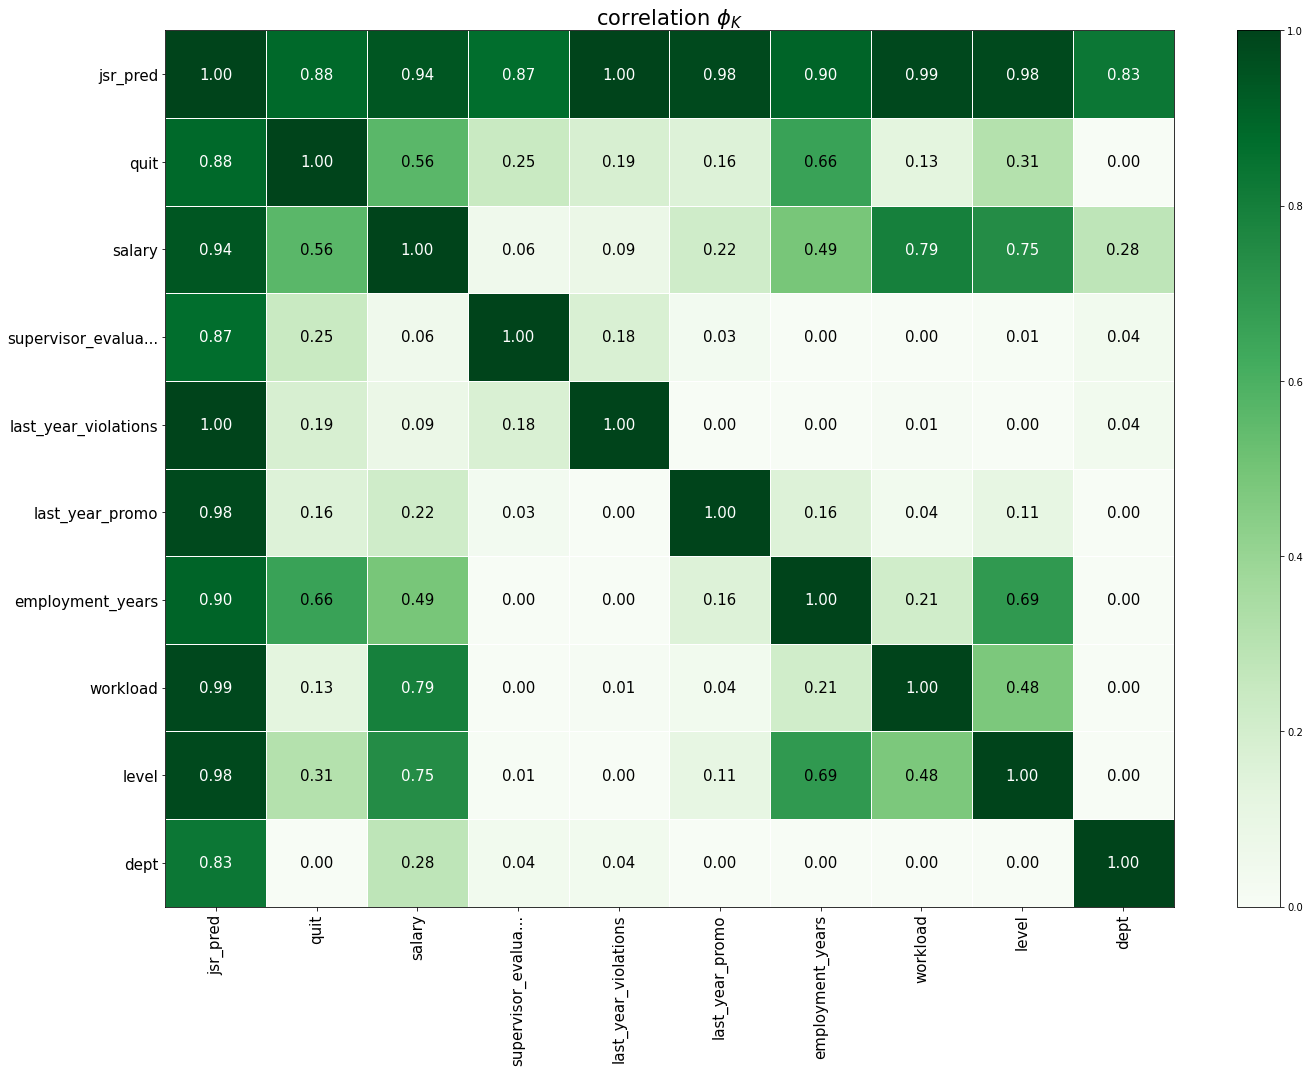

In [61]:
phik_overview = phik_matrix(df_train_quit, interval_cols=interval_cols[0]) #.drop('id', axis =1), interval_cols=interval_cols[0])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

In [62]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   jsr_pred               4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 472.8+ KB


In [63]:
display(df_train_quit.duplicated().sum())
#df_train_quit = df_train_quit.drop_duplicates()
#df_train_quit.info()

1413

признак dept не оказывает влияния на целевой показатель quit, поэтому уберем его из входящих признаков модели

In [64]:
X_train = df_train_quit.drop(['quit', 'dept'], axis = 1)
y_train = df_train_quit['quit']

X_test = df_quit_test.drop(['quit', 'dept'], axis = 1)
y_test = df_quit_test['quit']



In [65]:
display(X_train.shape)
display(y_train.shape)

(4000, 8)

(4000,)

id убрал (выше по коду), но настаиваю на том, чтобы на этот раз НЕ удалять дубликаты (которые, как оказалось, там есть) на том основании, что их удаление значимо снижает качество модели. А если, что на тренировочной, что на тестовой выборке - качество примерно одинаковое, то очевидно, что вопреки мнению об их "вредности" дубликаты наоборот, улучшают ее качество и не искажают ее(не переобучают например). При этом у нас просто деревянная модель работает лучше, чем остальные, но у нас же не было задачи добиться лучшего качества на какой-то определенной модели, поэтому предлагаю оставить эту модель. 

В противном случае просьба пояснить как наличие дубликатов в данном конкретном кейсе "вредит" качеству моделирования, учитывая, что результат на трен. и тестовой выборках практически идентичен. 

In [66]:
#добавим оверсэмплер для исключения дисбаланса классов
ros = RandomOverSampler(random_state = RANDOM_STATE)

# кодируем целевой признак
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [67]:
X_train.head()

,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,jsr_pred
id,,,,,,,,
723290,middle,high,2,no,no,4,54000,65.738095
814010,junior,medium,2,no,no,4,27600,82.400000
155091,middle,medium,5,no,no,1,37200,36.875000
257132,junior,medium,2,no,yes,3,24000,35.625000
910140,junior,medium,2,no,no,5,25200,82.400000


In [68]:
OHE_COLUMNS2 = ['last_year_promo', 'last_year_violations']
ORD_COLUMNS2 = ['level', 'workload']
NUM_COLUMNS2 = ['employment_years', 'supervisor_evaluation', 'salary', 'jsr_pred']

### 7.2 Создание нового пайплайна и поиск лучшей модели

In [69]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe_2 = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) #, sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий препроцессор для подготовки данных
data_preprocessor_2 = ColumnTransformer(
    [('ohe', ohe_pipe_2, OHE_COLUMNS2),
     ('ord', ord_pipe_2, ORD_COLUMNS2),
     ('num', StandardScaler(), NUM_COLUMNS2)
    ],
    remainder='passthrough'
)



параметры моделей:

In [70]:


param_grid_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1',
            class_weight='balanced',
                    
        )],
        'models__C': [0.1, 1, 10], #range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для 1 модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'poly',
            gamma = 0.4,
            C = [0.1,1,10,100],
            probability=True,
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }    
]

In [71]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2 = Pipeline([
    #('ros', ros), #RandomOverSampler()),
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [72]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    #cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_2.fit(X_train, y_train_encoded)

print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                           

In [73]:
display(X_train)

,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,jsr_pred
id,,,,,,,,
723290,middle,high,2,no,no,4,54000,65.738095
814010,junior,medium,2,no,no,4,27600,82.400000
155091,middle,medium,5,no,no,1,37200,36.875000
257132,junior,medium,2,no,yes,3,24000,35.625000
910140,junior,medium,2,no,no,5,25200,82.400000
...,...,...,...,...,...,...,...,...
588809,junior,medium,4,no,no,3,26400,50.685714
672059,middle,high,9,no,no,4,52800,83.264706
536432,junior,low,2,no,yes,4,12000,54.250000


In [74]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных

y_test_pred_3 = randomized_search_2.predict(X_test)
print(f'\n Лучшие параметры среди всех гиперпараметров:\n {randomized_search_2.best_params_}')
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_encoded, randomized_search_2.predict_proba(X_test)[:,1])}')


 Лучшие параметры среди всех гиперпараметров:
 {'preprocessor__num': 'passthrough', 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}
Метрика ROC-AUC на тестовой выборке: 0.9137644708508664


### 7.3 Выводы по 2 задаче

метрика лучшей модели = 0.9137 - задача выполнена.
Лучшей моделью оказалась DecisionTreeClassifier с параметрами (max_depth=4, max_features=4,
                                        random_state=42))])

## 8. Выводы

Перед нами стояли следующие задачи:
    Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании.
    
    1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, т.к. удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
    
    2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Этапы проделанных работ для решения задач:
1. Загрузили данные.
2. Осуществили предобработку данных (обработали дубликаты/пропуски).
3. Провели исследовательский анализ данных, выявили зависимости между признаками.
4. Подготовили данные для обучения моделей и поиска лучшей по 1 задаче.
5. Обучили модели и нашли лучшую.
6. По 2 задаче предобработали данные (добавили предсказанный прогноз удовлетворенности во входные параметры на основании вывода о том, что удовлетворенность оказывает влияние на вероятность увольнения).
7. Составили "портрет" уволившегося сотрудника, выделили наиболее характерные его черты.
8. Подготовили и нашли лучшую модель прогнозирования увольнения сотрудников.

Выводы и дополнительные предложения для бизнеса:

1. Лучшая модель по 1 задаче - DecisionTreeRegressor с параметрами:
(max_depth=99, max_leaf_nodes=170, min_samples_leaf=3, random_state=42))]).

2. Лучшая модель по 2 задаче -  LogisticRegression с параметрами:
(C=4, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear')).

3. Рекомендации для бизнеса:
    1. Учитывая, что самое большое влияние на первый целевой признак (удовлетворенность) оказывают признаки supervisor_evaluation, last_year_violations и employment_years, нужно уделять этим показателям повышенное внимание и стараться управлять ими.
    2. Учитывая, что, в свою очередь, удовлетворенность также оказывает значельное влияние на вероятность увольнения, разработать меры по повышению удовлетворенности сотрудников.
    3. Проанализировать основные характеристики "портрета" уволившегося сотрудника и уделять повышенное внимание сотрудникам, попавшим под описание "портрета".